In [1]:
#基于多数投票原则组合不同分类算法
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]],iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 1)

In [3]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty = 'l2',C = 0.001,random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1,criterion = 'entropy',random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1,p = 2,metric = 'minkowski')
pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic Regression','Decision Tree','KNN']
print('10-fold cross validation:\n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator = clf,X = X_train,y = y_train,cv = 10,scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [4]:
#集成学习
from sklearn.ensemble import VotingClassifier
mv_clf = VotingClassifier(estimators = [('lr',pipe1),('dt',clf2),('kn',pipe3)],voting='soft')

In [5]:
clf_labels += ['Majority Voting']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator = clf,X = X_train,y = y_train,cv = 10,scoring = 'roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


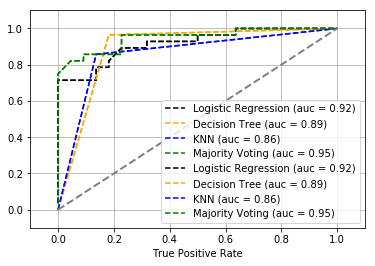

In [7]:
#评估与调优集成分类器
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']
for clf,label,clr,ls in zip(all_clf,clf_labels,colors,linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true = y_test,y_score = y_pred)
    roc_auc = auc(x = fpr,y = tpr)
    plt.plot(fpr,tpr,color=clr,linestyle = '--',
             label = '%s (auc = %0.2f)' % (label,roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],linestyle = '--',color = 'gray',linewidth = 2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.show()